<a href="https://colab.research.google.com/github/fifinayupuspitasari/cantik/blob/main/machine_learning_finish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MENDETEKSI TUMOR OTAK DENGAN CNN

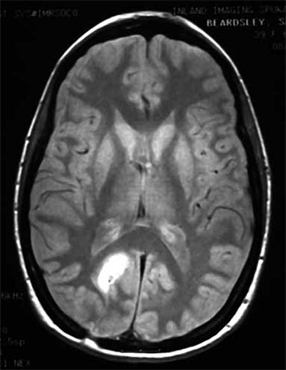

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


In [ ]:
from google.colab import drive
drive.mount('/content/drives/')

In [ ]:
path = "/content/drives/MyDrive/Dataset"

In [ ]:
list(os.listdir(path))

In [ ]:
list(os.listdir(path + "/Training"))

In [ ]:
list(os.listdir(path + "/Testing"))

---

# Color

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#582626", "#FF0000", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Persiapan Data

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Kita mulai dengan menambahkan semua gambar dari direktori ke dalam daftar Python dan kemudian mengubahnya menjadi array numpy setelah mengubah ukurannya.

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drives/MyDrive/Dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drives/MyDrive/Dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

Membagi himpunan data menjadi set Pelatihan dan Pengujian.

* Daftar item
* Daftar item



In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Melakukan **One Hot Encoding** pada label setelah mengubahnya menjadi nilai numerik:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Model jaringan saraf convolutional yang dalam mungkin memerlukan waktu berhari-hari atau bahkan berminggu-minggu untuk dilatih pada kumpulan data yang sangat besar.

Cara untuk mempersingkat proses ini adalah dengan menggunakan kembali bobot model dari model yang telah dilatih sebelumnya yang dikembangkan untuk kumpulan data benchmark visi komputer standar, seperti tugas pengenalan gambar ImageNet. Model berkinerja terbaik dapat diunduh dan digunakan secara langsung, atau diintegrasikan ke dalam model baru untuk masalah penglihatan komputer Anda sendiri.

Di notebook ini, saya akan menggunakan model EfficientNetB0 yang akan menggunakan bobot dari kumpulan data ImageNet.

Parameter include_top disetel ke *False* sehingga jaringan tidak menyertakan lapisan atas/lapisan keluaran dari model pra-bangun yang memungkinkan kita untuk menambahkan lapisan keluaran kita sendiri tergantung pada kasus penggunaan kita!

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

GlobalAveragePooling2D -> Lapisan ini bertindak mirip dengan lapisan Pengumpulan Maks di CNN, satu-satunya perbedaan adalah ia menggunakan nilai Rata-rata alih-alih nilai Maks saat *pengumpulan*. Ini sangat membantu dalam mengurangi beban komputasi pada mesin saat pelatihan.
<br><br>
Dropout -> Lapisan ini menghilangkan beberapa neuron pada setiap langkah dari lapisan membuat neuron lebih independen dari neuron tetangga. Ini membantu dalam menghindari overfitting. Neuron yang akan dihilangkan dipilih secara acak. Parameter rate adalah kemungkinan aktivasi neuron yang disetel ke 0, sehingga menghilangkan neuron

Dense -> Ini adalah lapisan keluaran yang mengklasifikasikan gambar ke dalam 1 dari 4 kemungkinan kelas. Ini menggunakan fungsi softmax yang merupakan generalisasi dari fungsi sigmoid.

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Kami akhirnya mengkompilasi model kami.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

Callback -> Callback dapat membantu Anda memperbaiki bug lebih cepat, dan dapat membantu Anda membuat model yang lebih baik. Mereka dapat membantu Anda memvisualisasikan bagaimana pelatihan model Anda berjalan, dan bahkan dapat membantu mencegah overfitting dengan menerapkan penghentian dini atau menyesuaikan kecepatan pembelajaran pada setiap iterasi.<br><br>
Menurut definisi, "Panggilan balik adalah sekumpulan fungsi yang akan diterapkan pada tahapan tertentu dari prosedur pelatihan. Anda dapat menggunakan panggilan balik untuk mendapatkan tampilan status internal dan statistik model selama pelatihan."

Di notebook ini, saya akan menggunakan fungsi panggilan balik TensorBoard, ModelCheckpoint, dan ReduceLROnPlateau

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training Model

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediksi

Saya telah menggunakan *fungsi argmax* karena setiap baris dari larik prediksi berisi empat nilai untuk masing-masing label. Nilai maksimum yang ada di setiap baris menggambarkan keluaran yang diprediksi dari 4 kemungkinan hasil.
Jadi dengan argmax, saya dapat mengetahui indeks yang terkait dengan hasil yang diprediksi.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

---

# Evaluation

dalam hal inii, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

kami telah membuat Widget ini di mana kami dapat mengunggah gambar dari mesin lokal kami dan memprediksi apakah pemindaian MRI memiliki Tumor Otak atau tidak dan untuk mengklasifikasikan Tumor itu.

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(224,224))
    img = img.reshape(1,224,224,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')



In [ ]:
uploader = widgets.FileUpload()
display(uploader)

Setelah mengunggah gambar, Anda dapat mengklik tombol Predict di bawah ini untuk membuat prediksi:

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])